# < 17. 난 스케치를 할 테니 너는 채색을 하거라 >

## 학습목표
- 조건을 부여하여 생성 모델을 다루는 방법에 대해 이해합니다.
- cGAN 및 Pix2Pix의 구조와 학습 방법을 이해하고 잘 활용합니다.
- CNN 기반의 모델을 구현하는데 자신감을 갖습니다.

---

## 17.2 조건 없는 생성모델(Unconditional Generative Model), GAN

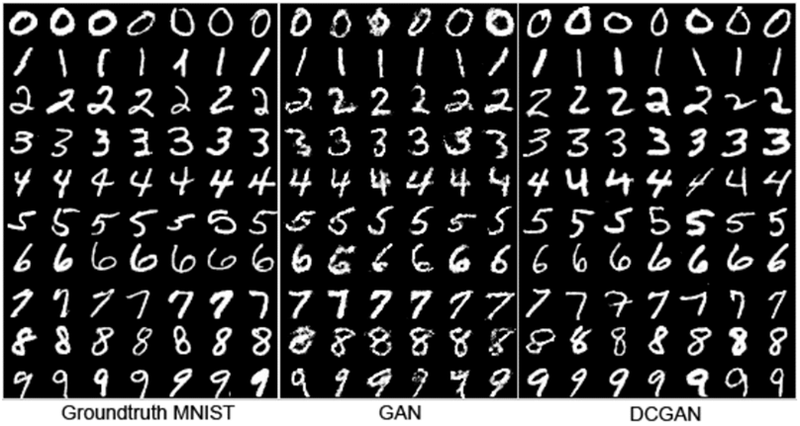

잘 학습된 GAN을 이용해 실제 이미지를 생성할 때 조금 답답한 점이 하나 있다면, 바로 내가 원하는 종류의 이미지를 바로 생성해 내지 못한다는 것입니다.
다시 말해서 일반적인 GAN과 같은 unconditioned generative model은 내가 생성하고자 하는 데이터에 대해 제어하기 힘들었습니다.

우리가 원하는 이미지를 바로바로 생성해 내기 위해서는 어떤 방법을 이용해야 할까요? GAN이라는 생성 모델에 내가 원하는 이미지를 만들기 위한 특정 조건을 줄 수는 없을까요?
기약 없이 "7"이라 쓰인 이미지가 생성되길 기다릴 순 없으니까요.

---

## 17.3 조건 있는 생성모델(Conditional Generative Model), cGAN

Conditional Generative Adversarial Nets (cGAN) 은 내가 원하는 종류의 이미지를 생성하고자 할 때 GAN이 가진 생성 과정의 불편함을 해소하여, 내가 원하는 종류의 이미지를 생성할 수 있도록 고안된 방법입니다.

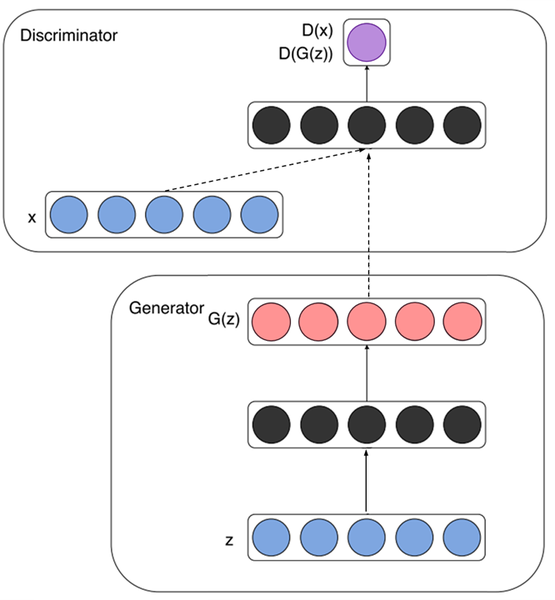

GAN의 학습 과정은 위 그림과 같습니다.

`Generator`
노이즈 zz(파란색)가 입력되고 특정 representation(검정색)으로 변환된 후 가짜 데이터 G(z)G(z) (빨간색)를 생성해 냅니다.

`Discriminator`
실제 데이터 xx와 Generator가 생성한 가짜 데이터 G(z)G(z)를 각각 입력받아 D(x)D(x) 및 D(G(z))D(G(z)) (보라색)를 계산하여 진짜와 가짜를 식별해 냅니다.

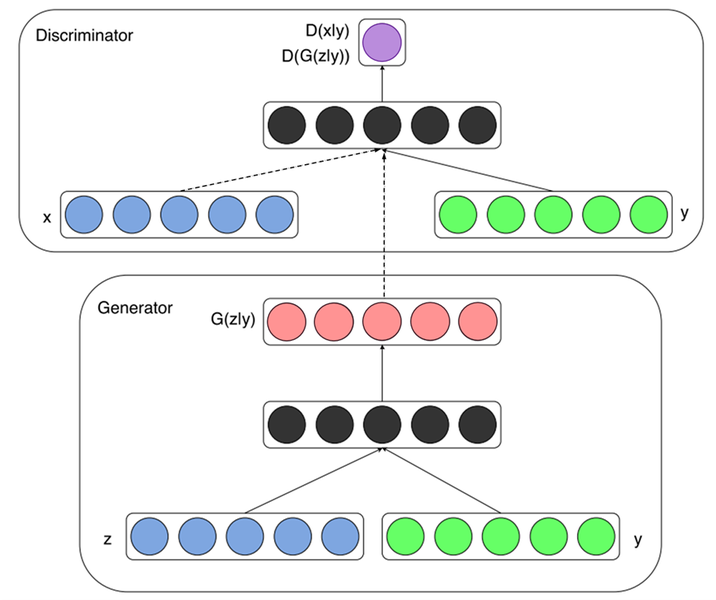

cGAN에서 바뀐 부분은 y라는 정보가 함께 입력된다는 것입니다.

`Generator`
노이즈 z(파란색)와 추가 정보 y(녹색)을 함께 입력받아 Generator 내부에서 결합되어 representation(검정색)으로 변환되며 가짜 데이터 G(z∣y)G(z∣y)를 생성합니다. MNIST나 CIFAR-10 등의 데이터셋에 대해 학습시키는 경우 y는 레이블 정보이며, 일반적으로 one-hot 벡터를 입력으로 넣습니다.

`Discriminator`
실제 데이터 x와 Generator가 생성한 가짜 데이터 G(z∣y)G(z∣y)를 각각 입력받으며, 마찬가지로 y정보가 각각 함께 입력되어 진짜와 가짜를 식별합니다. MNIST나 CIFAR-10 등의 데이터셋에 대해 학습시키는 경우 실제 데이터 x와 y는 알맞은 한 쌍("7"이라 쓰인 이미지의 경우 레이블도 7)을 이뤄야 하며, 마찬가지로 Generator에 입력된 y와 Discriminator에 입력되는 y는 동일한 레이블을 나타내야 합니다.

---

## 17.4 내가 원하는 숫자 이미지 만들기 (1) Generator 구성하기

### 데이터 준비하기

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /aiffel/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


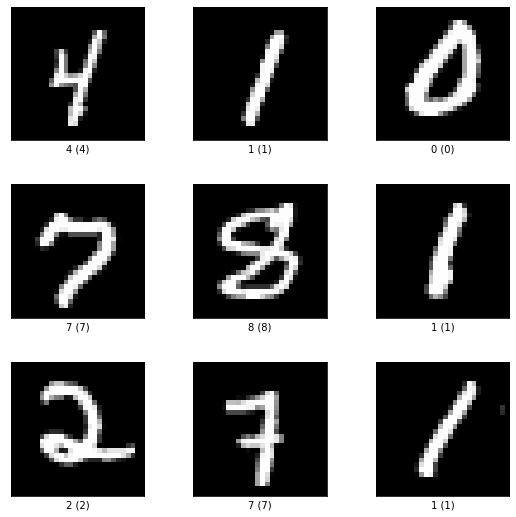

In [1]:
import tensorflow_datasets as tfds

mnist, info =  tfds.load(
    "mnist", split="train", with_info=True
)

fig = tfds.show_examples(mnist, info)

In [2]:
import tensorflow as tf

BATCH_SIZE = 128

def gan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def cgan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    
    label = tf.one_hot(data["label"], 10)
    return image, label

gan_datasets = mnist.map(gan_preprocessing).shuffle(1000).batch(BATCH_SIZE)
cgan_datasets = mnist.map(cgan_preprocessing).shuffle(100).batch(BATCH_SIZE)
print("✅")

✅


Label : tf.Tensor([0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], shape=(10,), dtype=float32)
Image Min/Max : -1.0 1.0


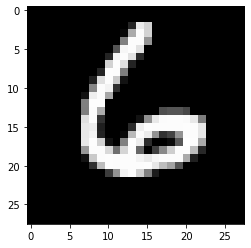

In [3]:
import matplotlib.pyplot as plt

for i,j in cgan_datasets : break

# 이미지 i와 라벨 j가 일치하는지 확인해 봅니다.     
print("Label :", j[0])
print("Image Min/Max :", i.numpy().min(), i.numpy().max())
plt.imshow(i.numpy()[0,...,0], plt.cm.gray)

### GAN Generator 구성하기
이번 구현은 Tensorflow2의 Subclassing 방법을 이용하겠습니다. Subclassing 방법은 tensorflow.keras.Model 을 상속받아 클래스를 만들며, 일반적으로 __init__() 메서드 안에서 레이어 구성을 정의하고, 구성된 레이어를 call() 메서드에서 사용해 forward propagation을 진행합니다. 

In [4]:
from tensorflow.keras import layers, Input, Model

class GeneratorGAN(Model):
    def __init__(self):
        super(GeneratorGAN, self).__init__()

        self.dense_1 = layers.Dense(128, activation='relu')
        self.dense_2 = layers.Dense(256, activation='relu')
        self.dense_3 = layers.Dense(512, activation='relu')
        self.dense_4 = layers.Dense(28*28*1, activation='tanh')

        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise):
        out = self.dense_1(noise)
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        return self.reshape(out)

print("✅")

✅


### cGAN Generator 구성하기

In [5]:
class GeneratorCGAN(Model):
    def __init__(self):
        super(GeneratorCGAN, self).__init__()
        
        self.dense_z = layers.Dense(256, activation='relu')
        self.dense_y = layers.Dense(256, activation='relu')
        self.combined_dense = layers.Dense(512, activation='relu')
        self.final_dense = layers.Dense(28 * 28 * 1, activation='tanh')
        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise, label):
        noise = self.dense_z(noise)
        label = self.dense_y(label)
        out = self.combined_dense(tf.concat([noise, label], axis=-1))
        out = self.final_dense(out)
        return self.reshape(out)
    
print("✅")

✅


GAN의 Generator보다 구현이 복잡한듯하지만, 이전에 cGAN을 이해한 대로 두 구조의 차이점은 레이블 정보가 추가된다는 것뿐입니다. 이번에는 여러분이 위 코드를 자세히 보고, 어떠한 연산이 이루어지는지 생각해 봅시다.
cGAN의 입력은 2개(노이즈 및 레이블 정보)라는 점을 기억해 주세요.

1. 노이즈 입력 및 레이블 입력은 각각 1개의 fully-connected 레이어와 ReLU 활성화를 통과합니다. (dense_z, dense_y)
2. 1번 문항의 각 결과가 서로 연결되어 다시 한번 1개의 fully-connected 레이어와 ReLU 활성화를 통과합니다 (tf.concat, conbined_dense)
3. 2번 문항의 결과가 1개의 fully-connected 레이어 및 Hyperbolic tangent 활성화를 거쳐 28x28 차원의 결과가 생성되고 (28,28,1) 크기의 이미지 형태로 변환되어 출력됩니다 (final_dense, reshape)

---

## 17.5 내가 원하는 숫자 이미지 만들기 (2) Discriminator 구성하기

### GAN Discriminator 구성하기

In [6]:
class DiscriminatorGAN(Model):
    def __init__(self):
        super(DiscriminatorGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.blocks = []
        for f in [512, 256, 128, 1]:
            self.blocks.append(
                layers.Dense(f, activation=None if f==1 else "relu")
            )
        
    def call(self, x):
        x = self.flatten(x)
        for block in self.blocks:
            x = block(x)
        return x
    
print("✅")

✅


여기에서는 \__init__()에 blocks라는 리스트를 하나 만들어 놓고, for loop를 이용하여 필요한 레이어들을 차곡차곡 쌓아놓았습니다. 이러한 방식을 이용하면 각각의 fully-connected 레이어를 매번 정의하지 않아도 되므로 많은 레이어가 필요할 때 편리합니다. Discriminator의 입력은 Generator가 생성한 (28,28,1) 크기의 이미지이며, 이를 fully-connected 레이어로 학습하기 위해 call()에서는 가장 먼저 layers.Flatten()이 적용됩니다. 이어서 레이어들이 쌓여있는 blocks에 대해 for loop를 이용하여 레이어들을 순서대로 하나씩 꺼내 입력 데이터를 통과시킵니다. 마지막 fully-connected 레이어를 통과하면 진짜 및 가짜 이미지를 나타내는 1개의 값이 출력됩니다.

### cGAN Discriminator 구성하기

In [7]:
class Maxout(layers.Layer):
    def __init__(self, units, pieces):
        super(Maxout, self).__init__()
        self.dense = layers.Dense(units*pieces, activation="relu")
        self.dropout = layers.Dropout(.5)    
        self.reshape = layers.Reshape((-1, pieces, units))
    
    def call(self, x):
        x = self.dense(x)
        x = self.dropout(x)
        x = self.reshape(x)
        return tf.math.reduce_max(x, axis=2)

print("✅")

✅


Maxout 레이어를 구성할 때 units과 pieces의 설정이 필요하며, units 차원 수를 가진 fully-connected 레이어를 pieces개만큼 만들고 그중 최댓값을 출력합니다. 예를 들어, 사용할 Maxout 레이어가 units=100, pieces=10으로 설정된다면 입력으로부터 100차원의 representation을 10개 만들고, 10개 중에서 최댓값을 가져와 최종 1개의 100차원 representation이 출력됩니다. 식으로 나타낸다면 아래와 같습니다. (위 예시에서는 각각의 wx+b가 모두 100차원입니다)

In [8]:
class DiscriminatorCGAN(Model):
    def __init__(self):
        super(DiscriminatorCGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.image_block = Maxout(240, 5)
        self.label_block = Maxout(50, 5)
        self.combine_block = Maxout(240, 4)
        
        self.dense = layers.Dense(1, activation=None)
    
    def call(self, image, label):
        image = self.flatten(image)
        image = self.image_block(image)
        label = self.label_block(label)
        x = layers.Concatenate()([image, label])
        x = self.combine_block(x)
        return self.dense(x)
    
print("✅")

✅


---

## 17.6 내가 원하는 숫자 이미지 만들기 (3) 학습 및 테스트하기

In [9]:
from tensorflow.keras import optimizers, losses

bce = losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    return bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(fake_output), fake_output)

gene_opt = optimizers.Adam(1e-4)
disc_opt = optimizers.Adam(1e-4)    

print("✅")

✅


### GAN으로 MNIST 학습하기

In [10]:
gan_generator = GeneratorGAN()
gan_discriminator = DiscriminatorGAN()

@tf.function()
def gan_step(real_images):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        # Generator를 이용해 가짜 이미지 생성
        fake_images = gan_generator(noise)
        # Discriminator를 이용해 진짜 및 가짜이미지를 각각 판별
        real_out = gan_discriminator(real_images)
        fake_out = gan_discriminator(fake_images)
        # 각 손실(loss)을 계산
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    # gradient 계산
    gene_grad = tape.gradient(gene_loss, gan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, gan_discriminator.trainable_variables)
    # 모델 학습
    gene_opt.apply_gradients(zip(gene_grad, gan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, gan_discriminator.trainable_variables))
    return gene_loss, disc_loss

print("✅")

✅


In [11]:
EPOCHS = 10
for epoch in range(1, EPOCHS+1):
    for i, images in enumerate(gan_datasets):
        gene_loss, disc_loss = gan_step(images)

        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i+1} ITER] G:{gene_loss}, D:{disc_loss}")

[1/10 EPOCHS, 100 ITER] G:2.0953423976898193, D:0.14487433433532715
[1/10 EPOCHS, 200 ITER] G:2.3170337677001953, D:0.12707284092903137
[1/10 EPOCHS, 300 ITER] G:2.5774986743927, D:0.10806069523096085
[1/10 EPOCHS, 400 ITER] G:3.3758463859558105, D:0.08258429914712906
[2/10 EPOCHS, 100 ITER] G:2.883547306060791, D:0.16390633583068848
[2/10 EPOCHS, 200 ITER] G:2.8117806911468506, D:0.23478743433952332
[2/10 EPOCHS, 300 ITER] G:2.8292360305786133, D:0.19630619883537292
[2/10 EPOCHS, 400 ITER] G:3.8347561359405518, D:0.0870061069726944
[3/10 EPOCHS, 100 ITER] G:3.9663753509521484, D:0.11721894145011902
[3/10 EPOCHS, 200 ITER] G:3.335489511489868, D:0.12261296808719635
[3/10 EPOCHS, 300 ITER] G:3.5132932662963867, D:0.06159793213009834
[3/10 EPOCHS, 400 ITER] G:3.590914011001587, D:0.10832587629556656
[4/10 EPOCHS, 100 ITER] G:4.368670463562012, D:0.029711587354540825
[4/10 EPOCHS, 200 ITER] G:4.232880115509033, D:0.11638562381267548
[4/10 EPOCHS, 300 ITER] G:4.493876934051514, D:0.0809341

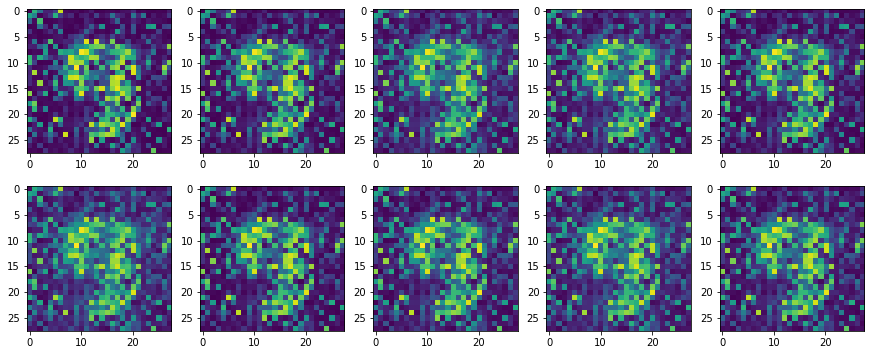

In [12]:
import numpy as np

noise = tf.random.normal([10, 100])

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

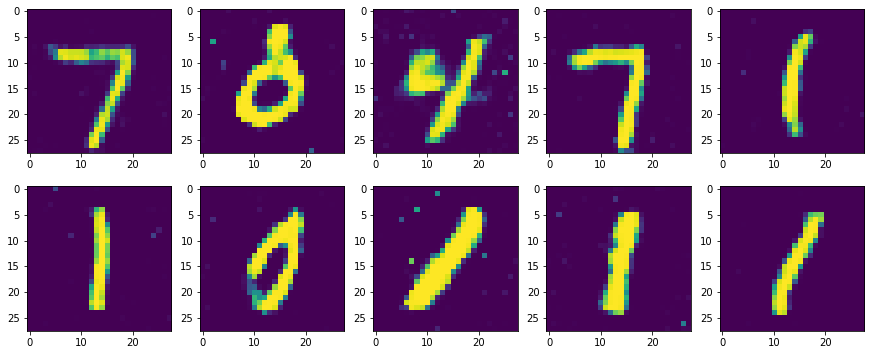

In [13]:
import os
weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/gan/GAN_500'

noise = tf.random.normal([10, 100]) 

gan_generator = GeneratorGAN()
gan_generator.load_weights(weight_path)

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

### cGAN으로 MNIST 학습하기

In [14]:
cgan_generator = GeneratorCGAN()
cgan_discriminator = DiscriminatorCGAN()

@tf.function()
def cgan_step(real_images, labels):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        fake_images = cgan_generator(noise, labels)
        
        real_out = cgan_discriminator(real_images, labels)
        fake_out = cgan_discriminator(fake_images, labels)
        
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    
    gene_grad = tape.gradient(gene_loss, cgan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, cgan_discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_grad, cgan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, cgan_discriminator.trainable_variables))
    return gene_loss, disc_loss


EPOCHS = 1
for epoch in range(1, EPOCHS+1):
    
    for i, (images, labels) in enumerate(cgan_datasets):
        gene_loss, disc_loss = cgan_step(images, labels)
    
        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i} ITER] G:{gene_loss}, D:{disc_loss}")

[1/1 EPOCHS, 99 ITER] G:5.270869255065918, D:0.007602098397910595
[1/1 EPOCHS, 199 ITER] G:3.8053267002105713, D:0.33974024653434753
[1/1 EPOCHS, 299 ITER] G:3.4728586673736572, D:0.09371641278266907
[1/1 EPOCHS, 399 ITER] G:4.775051116943359, D:0.0377514585852623


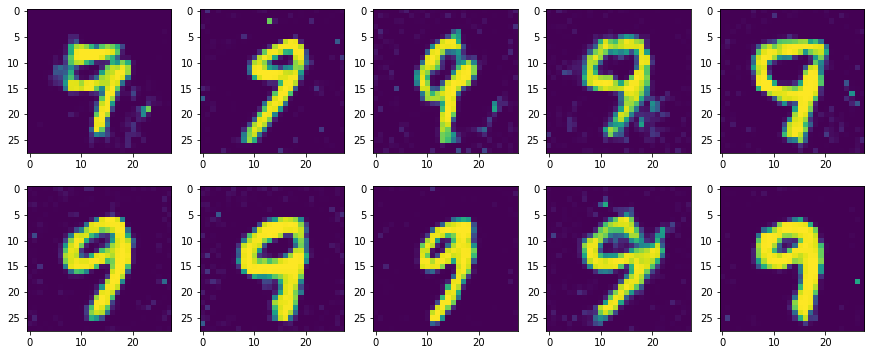

In [15]:
number = 9   # TODO : 생성할 숫자를 입력해 주세요!!

weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/cgan/CGAN_500'

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)
label = tf.expand_dims(label, axis=0)
label = tf.repeat(label, 10, axis=0)

generator = GeneratorCGAN()
generator.load_weights(weight_path)

output = generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

---

## 17.7 GAN의 입력에 이미지를 넣는다면? Pix2Pix

지금까지 cGAN에 대해 알아보고 실험해 보면서, 작은 조건만으로 우리가 원하는 클래스의 이미지를 생성할 수 있음을 확인했습니다. 만약 입력 자체가 조건이 된다면 어떨까요? cGAN과 같이 클래스 레이블 등의 조건을 함께 입력하는 것이 아니라, 조금 더 자세하게 내가 원하는 이미지를 얻기 위해 이미지를 조건으로 줄 수 없을까요? 이번에 소개드릴` Pix2Pix`는 기존 노이즈 입력을 이미지로 변환하는 일반적인 GAN이 아니라, 이미지를 입력으로 하여 원하는 다른 형태의 이미지로 변환시킬 수 있는 GAN 모델입니다.

Image-to-Image Translation은 말 그대로 이미지 간 변환을 말합니다

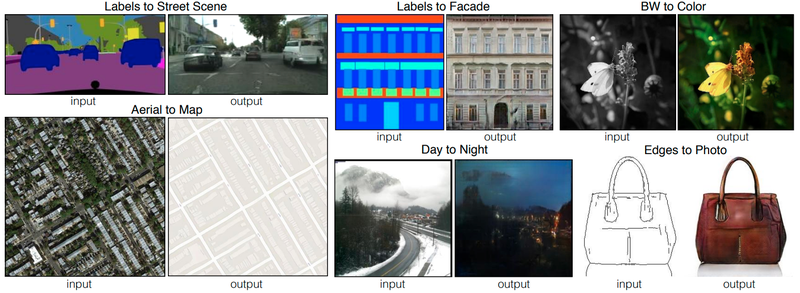
위 결과의 첫 번째 Labels to Street Scene 이미지는 픽셀 별로 레이블 정보만 존재하는 segmentation map을 입력으로 실제 거리 사진을 생성해 내었고, 이 외에 흑백 사진을 컬러로 변환하거나, 낮에 찍은 사진을 밤에 찍은 사진으로 변환하거나, 가방 스케치를 이용해 채색된 가방을 만들기도 합니다.

한 이미지의 픽셀에서 다른 이미지의 픽셀로(pixel to pixel) 변환한다는 뜻에서 Pix2Pix라는 이름으로 불립니다. 이 구조는 최근 활발하게 연구 및 응용되는 GAN 기반의 Image-to-Image Translation 작업에서 가장 기초가 되는 연구입니다.

노이즈와 레이블 정보를 함께 입력했던 cGAN은 fully-connected 레이어를 연속적으로 쌓아 만들었지만, 이미지 변환이 목적인 Pix2Pix는 이미지를 다루는데 효율적인 convolution 레이어를 활용합니다. GAN 구조를 기반으로 하기 때문에 크게 Generator와 Discriminator 두 가지 구성 요소로 이루어집니다. 아래에서 자세히 알아보겠습니다.

### Pix2Pix (Generator)
Generator는 어떠한 이미지를 입력받아 변환된 이미지를 출력하기 위해 사용됩니다. 여기서 입력 이미지와 변환된 이미지의 크기는 동일해야 하며, 이러한 문제에서 흔히 사용되는 구조는 아래 그림과 같은 Encoder-Decoder 구조입니다.

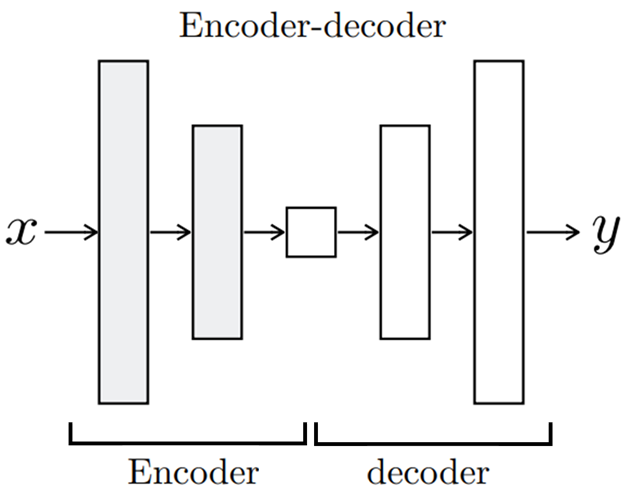

Encoder에서 입력 이미지(x)를 받으면 단계적으로 이미지를 down-sampling 하면서 입력 이미지의 중요한 representation을 학습합니다. Decoder에서는 이를 이용해 반대로 다시 이미지를 up-sampling하여 입력 이미지와 동일한 크기의 변환된 이미지(y)를 생성해냅니다. 이러한 과정은 모두 convolution 레이어로 진행되며, 레이어 내의 수많은 파라미터를 학습하여 잘 변환된 이미지를 얻도록 합니다. 여기서 한 가지 짚고 넘어갈 부분은, Encoder의 최종 출력은 위 그림 중간에 위치한 가장 작은 사각형이며, bottleneck 이라고도 불리는 이 부분은 입력 이미지(x)의 가장 중요한 특징만을 담고 있습니다.

과연 이 중요하지만 작은 특징이 변환된 이미지(y)를 생성하는데 충분한 정보를 제공할까요? 이와 같은 점을 보완하기 위해 논문에서는 Generator 구조를 하나 더 제안합니다.
아래 그림과 같은 U-Net 구조입니다.


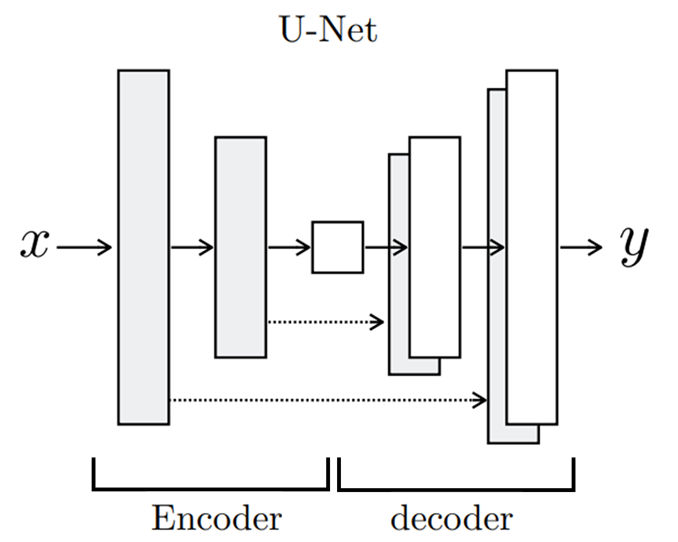

위에서 살펴본 단순한 Encoder-Decoder로 구성된 Generator와 다른 점은, 각 레이어마다 Encoder와 Decoder가 연결(skip connection)되어 있다는 것입니다. Decoder가 변환된 이미지를 더 잘 생성하도록 Encoder로부터 더 많은 추가 정보를 이용하는 방법이며, 이러한 U-Net 구조의 Generator를 사용해 아래와 같이 단순한 Encoder-Decoder 구조의 Generator를 사용한 결과에 비해 비교적 선명한 결과를 얻을 수 있었습니다.


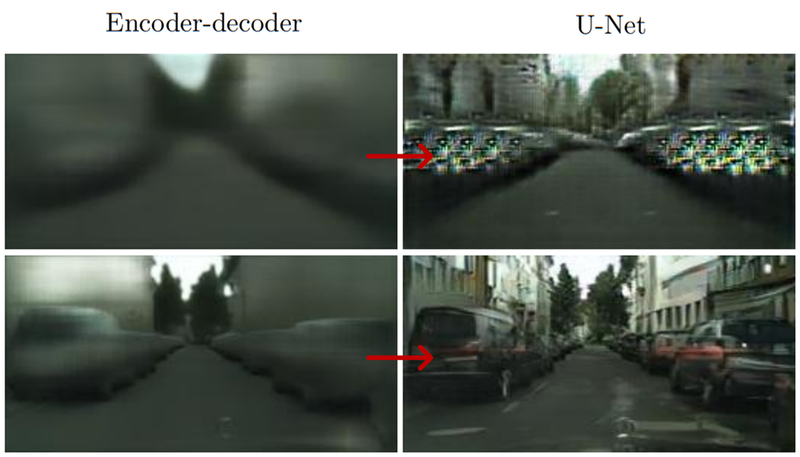
여기서 U-Net은 이전에 segmentation 작업을 위해 제안된 구조입니다. 


### Pix2Pix (Loss Function)

Generator만으로도 이미지 변환이 가능하지 않을까?

당연하게도 변환하고자 하는 이미지를 Encoder에 입력하여 Decoder의 출력으로 변환된 이미지를 얻을 수 있습니다. 출력된 이미지와 실제 이미지의 차이로 L2(MSE), L1(MAE) 같은 손실을 계산한 후 이를 역전파하여 네트워크를 학습시키면 되겠죠. 이미지 변환이 가능은 하지만 문제는 변환된 이미지의 품질입니다. 아래 사진의 L1이라 써있는 결과가 Generator 만을 사용해 변환된 이미지와 실제 이미지 사이의 L1 손실을 이용해 만들어낸 결과입니다.

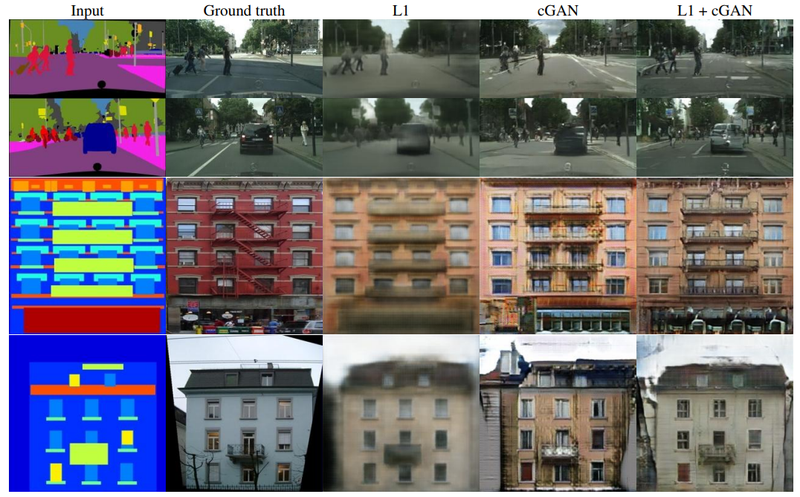

L1 이라 쓰여있는 Generator만으로 생성된 결과는 매우 흐릿합니다. 이미지를 변환하는데 L1(MAE)이나 L2(MSE) 손실만을 이용해서 학습하는 경우 이렇게 결과가 흐릿해지는 경향이 있습니다. Generator가 단순히 이미지의 평균적인 손실만을 줄이고자 파라미터를 학습하기 때문에 이러한 현상이 불가피합니다.

반면 위 그림의 cGAN이라 쓰여진 GAN 기반의 학습 방법은 비교적 훨씬 더 세밀한 정보를 잘 표현하고 있습니다. Discriminator를 잘 속이려면 Generator가 (Ground truth라고 쓰여진 이미지같이) 진짜 같은 이미지를 만들어야 하기 때문이죠. 논문에서는 L1손실과 GAN 손실을 같이 사용하면 더욱더 좋은 결과를 얻을 수 있다고 합니다 (위 그림의 L1+cGAN).

### Pix2Pix (Discriminator)
위 결과에서 보듯 실제 같은 이미지를 얻기 위해서는 GAN의 학습 방법을 이용해야 하며, 위에서 설명한 Generator를 발전시킬 서포터이자 경쟁자, Discriminator가 필요하겠죠

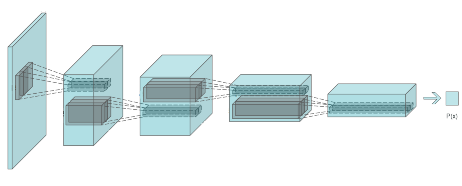

DCGAN의 Discriminator는 생성된 가짜 이미지 혹은 진짜 이미지를 하나씩 입력받아 convolution 레이어를 이용해 점점 크기를 줄여나가면서, 최종적으로 하나의 이미지에 대해 하나의 확률 값을 출력했습니다. Pix2Pix는 이 과정에서 의문을 갖습니다.

하나의 전체 이미지에 대해 하나의 확률 값만을 도출하는 것이 진짜 혹은 가짜를 판별하는 데 좋은 것일까?

Pix2Pix는 이러한 의문점을 가지고 아래 그림과 같은 조금 다른 방식의 Discriminator를 사용합니다.

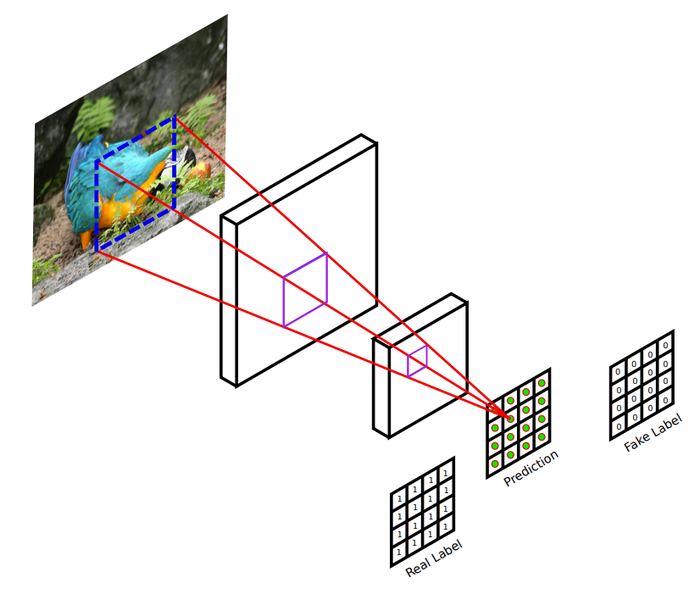

위 그림은 Pix2Pix에서 사용되는 Discriminator를 간략하게 나타냅니다. 하나의 이미지가 Discriminator의 입력으로 들어오면, convolution 레이어를 거쳐 확률 값을 나타내는 최종 결과를 생성하는데, 그 결과는 하나의 값이 아닌 여러 개의 값을 갖습니다 (위 그림의 Prediction은 16개의 값을 가지고 있습니다). 위 그림에서 입력 이미지의 파란색 점선은 여러 개의 출력 중 하나의 출력을 계산하기 위한 입력 이미지의 receptive field 영역을 나타내고 있으며, 전체 영역을 다 보는 것이 아닌 일부 영역(파란색 점선)에 대해서만 진짜/가짜를 판별하는 하나의 확률 값을 도출한다는 것입니다.

이런 방식으로 서로 다른 영역에 대해 진짜/가짜를 나타내는 여러 개의 확률 값을 계산할 수 있으며 이 값을 평균하여 최종 Discriminator의 출력을 생성합니다. 이러한 방법은 이미지의 일부 영역(patch)을 이용한다고 하여 `PatchGAN`이라고 불립니다. 일반적으로 이미지에서 거리가 먼 두 픽셀은 서로 연관성이 거의 없기 때문에 특정 크기를 가진 일부 영역에 대해서 세부적으로 진짜/가짜를 판별하는 것이 Generator로 하여금 더 진짜 같은 이미지를 만들도록 하는 방법입니다.

---

## 17.8 난 스케치를 할 테니 너는 채색을 하거라 (1) 데이터 준비하기

In [16]:
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/data/pokemon_pix2pix_dataset/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 830


#### 임의로 6장 선택하여 시각화

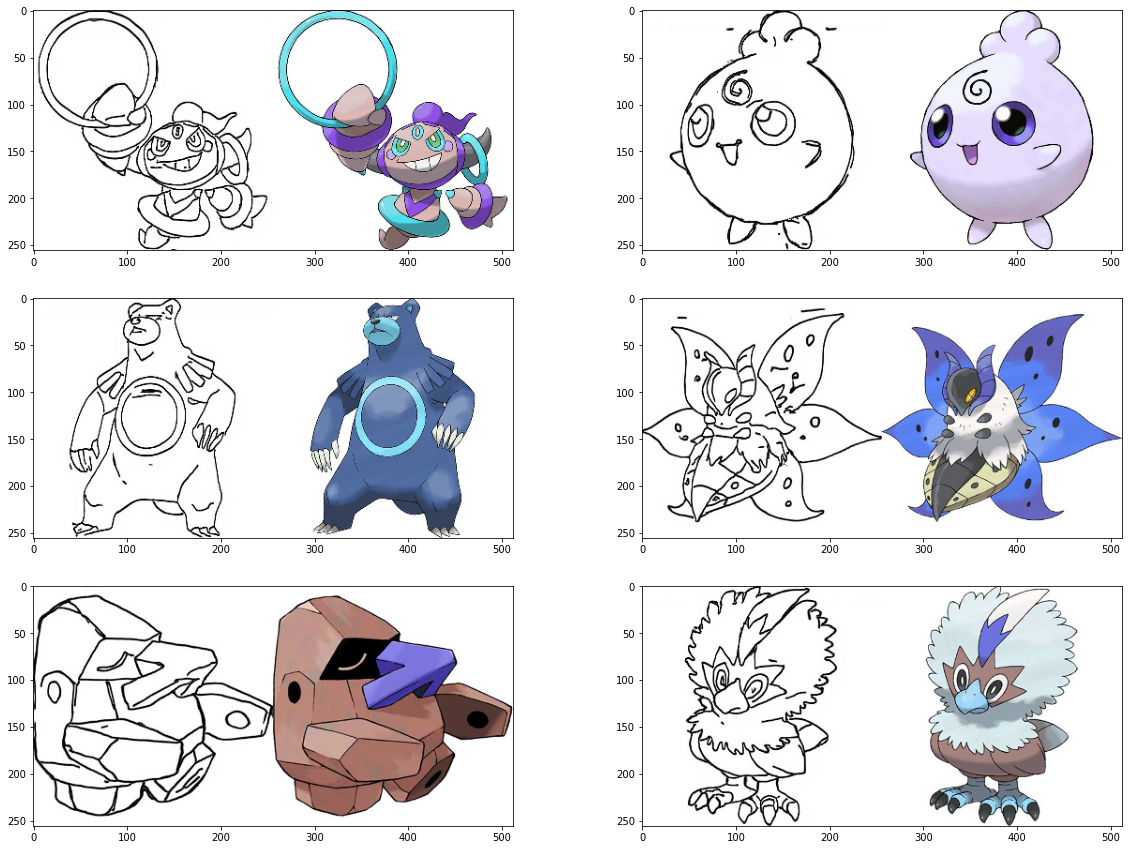

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [19]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


> 모델 학습에 사용할 데이터를 (256, 256, 3) 크기의 2개 이미지로 분할하여 사용

#### 이미지를 나누는 코드

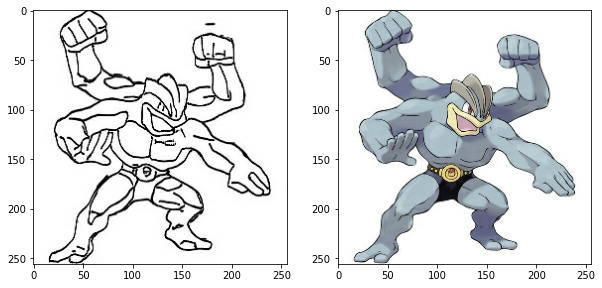

In [20]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

앞서 살펴봤듯이 학습에 사용할 수 있는 데이터의 수는 약 800개뿐입니다. 학습에 사용하는 데이터의 다양성을 높이기 위해 아래 코드와 같이 여러 augmentation 방법을 적용해 보겠습니다.

In [21]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


#### `apply_augmentation`
1. 두 이미지가 채널 축으로 연결됩니다. (tf.concat). 두 이미지가 각각 3채널인 경우 6채널이 됩니다.
2. 1.의 결과에 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼적용됩니다. (tf.pad)
3. 2.의 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 잘라냅니다. (tf.image.random_crop)
4. 3.의 결과를 50% 확률로 가로로 뒤집습니다. (tf.image.random_flip_left_right)
5. 4.의 결과를 50% 확률로 세로로 뒤집습니다. (tf.image.random_flip_up_down)
6. 5.의 결과를 50% 확률로 회전시킵니다. (tf.image.rot90)

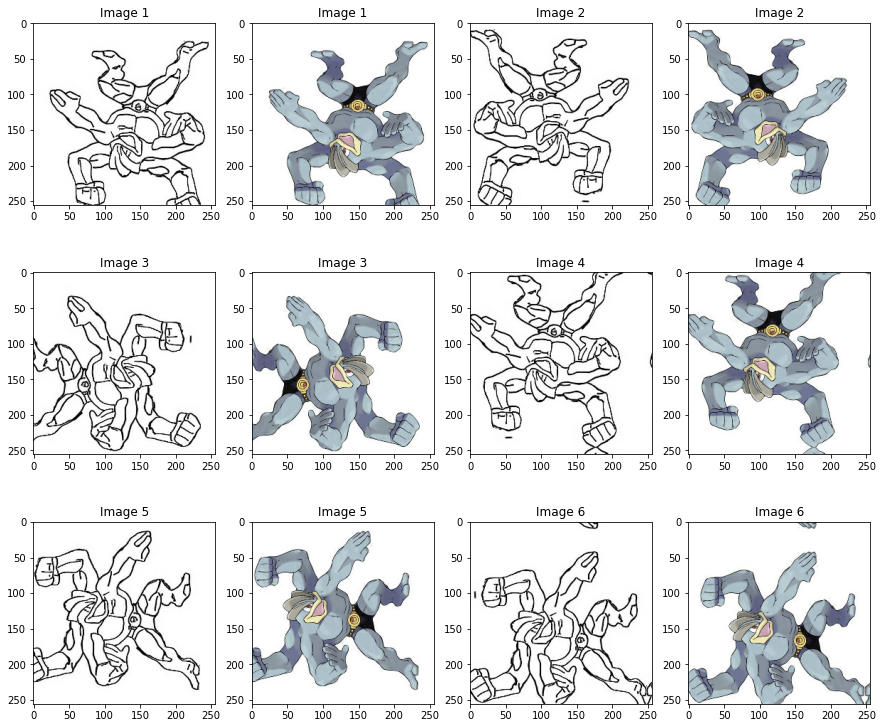

In [22]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

#### 학습 데이터에 작용하며 잘 적용되었는지 하나의 이미지만 시각화하여 확인

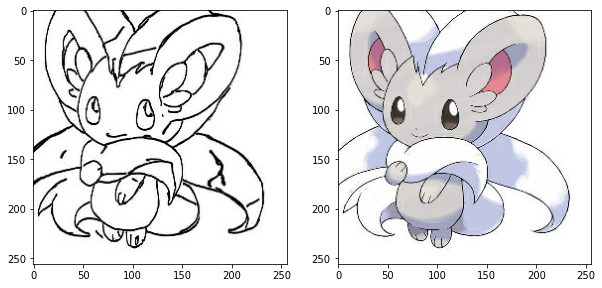

In [23]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

---

## 17.9 난 스케치를 할 테니 너는 채색을 하거라 (2) Generator 구성하기
- 앞서 cGAN 구현과 같이 Tensorflow의 Subclassing 방법을 이용해 모델을 만들겠습니다.

### Generator의 구성요소 알아보기

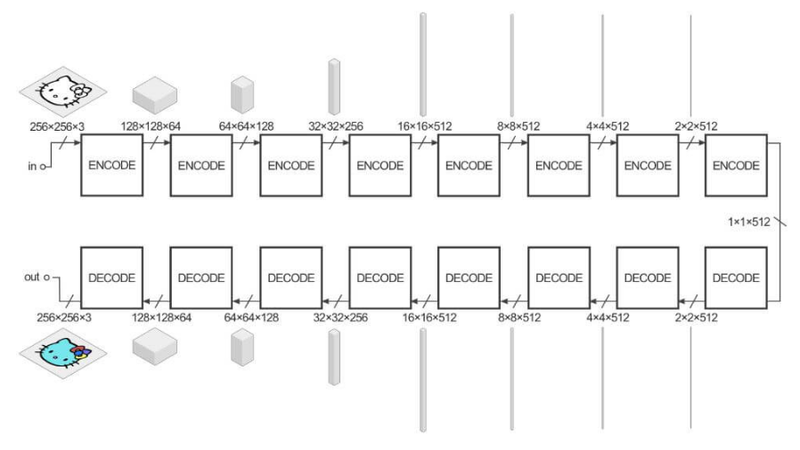

위 그림에서 ENCODE 또는 DECODE라고 쓰인 각각의 블록을 기준으로 양쪽에 쓰인 입출력 크기에 집중해 주세요.
"in"이라고 쓰여진 입력 부분부터 윗줄의 화살표를 쭉 따라가면 계산된 결과의 (width, height) 크기가 점점 절반씩 줄어들며 최종적으로 (1,1)이 되고, 채널의 수는 512까지 늘어나는 것을 확인할 수 있습니다.
처음 입력부터 시작해서 (1,1,512) 크기를 출력하는 곳까지가 Encoder 부분입니다.

이어서 아랫줄 화살표를 따라가면 (width, height) 크기가 점점 두 배로 늘어나 다시 (256, 256) 크기가 되고, 채널의 수는 점점 줄어들어 처음 입력과 같이 3채널이 됩니다. (1,1,512)를 입력으로 최종 출력까지의 연산들이 Decoder 부분입니다.

### Generator 구현하기

In [24]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅")

✅


In [25]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


각 블록을 거치면서 사용할 필터의 개수를 `filters`라는 리스트에 지정해 두었으며, `blocks`이라는 리스트에는 사용할 블록들을 정의해 넣어두고, `call()` 메서드에서 차례대로 블록들을 통과합니다. 앞서 퀴즈로 알아본 것처럼 Encoder 첫 번째 블록에서는 BatchNorm을 사용하지 않습니다.
`get_summary`는 레이어가 제대로 구성되었는지 확인하기 위한 용도로 따로 만들어 놓았습니다. 위에서 구성한 Encoder에 (256,256,3) 크기의 데이터를 입력했을 때, 어떤 크기의 데이터가 출력되는지 살펴봅시다. 만들어 놓은 get_summary 메서드를 바로 불러오시면 됩니다.

In [26]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

In [27]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
print("✅")

✅


처음 세 개의 블록에서만 `Dropout`을 사용했으며, 마지막 convolution에는 3개의 필터를 사용해 출력하는 것을 확인할 수 있습니다.

In [28]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 512)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         4196352   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

In [29]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


---

## 17.10 난 스케치를 할 테니 너는 채색을 하거라 (3) Generator 재구성하기

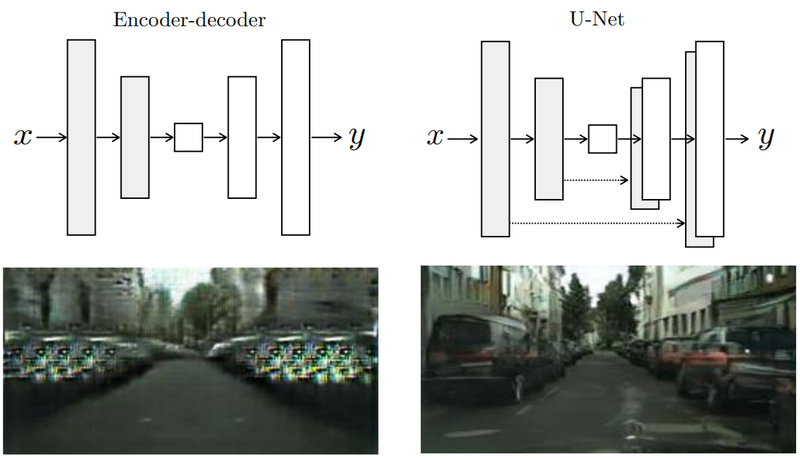

단순한 Encoder-Decoder 구조에 비해 Encoder와 Decoder 사이를 skip connection으로 연결한 U-Net 구조를 사용한 결과가 훨씬 더 실제 이미지에 가까운 품질을 보입니다.

전 단계에서 구현했던 Generator는 위 그림의 Encoder-decoder 구조입니다.
Encoder에서 출력된 결과를 Decoder의 입력으로 연결했고, 이 외에 추가적으로 Encoder와 Decoder를 연결시키는 부분은 없었습니다. 더 좋은 결과를 기대하기 위해 이전에 구현했던 것들을 조금 수정하여 위 그림의 U-Net 구조를 만들고 실험해 봅시다.
(아래 단락부터는 두 가지 구조를 각각 "Encoder-Decoder Generator" 및 "U-Net Generator"라는 용어로 구분하여 사용하겠습니다)

In [30]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


아래 모델의 \__init__() 메서드에서 Encoder 및 Decoder에서 사용할 모든 블록들을 정의해 놓고, call()에서 `forward propagation` 하도록 합니다.

In [31]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []                                # 리스트를 만들고 
        for block in self.encode_blocks:            # Encoder내에서 사용된 각 블록들의 출력을 차례대로 담음
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])      # features 리스트에 있는 각각의 출력들이 Decoder 블록 연산 후 함께 연
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


#### features = features[:-1] 는 왜 필요할까?
- Skip connection을 위해 만들어진 features 리스트에는 Encoder 내 각 블록의 출력이 들어있는데, Encoder의 마지막 출력(feature리스트 의 마지막 항목)은 Decoder로 직접 입력되므로 skip connection의 대상이 아닙니다.

#### Decoder 연산 부분에서 features[::-1] 는 왜 필요할까?
- Skip connection은 Encoder 내 첫 번째 블록의 출력이 Decoder의 마지막 블록에 연결되고, Encoder 내 두 번째 블록의 출력이 Decoder의 뒤에서 2번째 블록에 연결되는.. 등 대칭을 이룹니다(맨 위 U-Net 구조 사진 참고). features에는 Encoder 블록들의 출력들이 순서대로 쌓여있고, 이를 Decoder에서 차례대로 사용하기 위해서 features의 역순으로 연결합니다.

In [32]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
____________________________________________________________________________________________

---

## 17.11 난 스케치를 할 테니 너는 채색을 하거라 (4) Discriminator 구성하기

### Discriminator의 구성요소 알아보기

Generator의 구성 요소와 똑같이 "C64" 등으로 표기되어 있습니다. 진짜 및 가짜 이미지를 판별하기 위해 최종 출력에 sigmoid를 사용하는 것을 제외하면 특별한 변경 사항은 없는 것 같습니다.

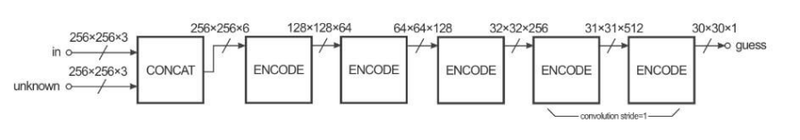

Discriminator는 2개 입력(위 그림의 "in", "unknown")을 받아 연결(CONCAT)한 후, ENCODE 라고 쓰인 5개의 블록을 통과합니다. 이 중 마지막 블록을 제외한 4개 블록은 위 논문에서 표기된 "C64-C128-C256-C512"에 해당하며, 마지막은 1(채널)차원 출력을 위한 블록이 추가되었습니다.

최종적으로 출력되는 크기는 (30,30,1) 이며, 위 그림의 출력 이전의 2개의 ENCODE 블록을 보면 각각의 출력 크기가 32, 31, 30으로 1씩 감소하는 것을 알 수 있습니다. Generator에서도 사용했던 2 stride convolution에 패딩을 이용하면 (width, height) 크기가 절반씩 감소할 것입니다. 1 stride convolution에 패딩을 하지 않는다면 (width, height) 크기는 (필터 크기가 4이므로) 3씩 감소할 텐데, 그림과 같이 1씩 감소하도록 하려면 무언가 다른 방법을 써야 할 것 같다.

추가적으로 위 그림에서 최종 출력 크기가 (30,30,1)이 되어야 하는 이유는 앞서 Discriminator에 대해 알아봤던 70x70 PatchGAN을 사용했기 때문입니다. 최종 (30,30) 출력에서 각 픽셀의 receptive field 크기를 (70,70)으로 맞추기 위해 Discriminator의 출력 크기를 (30,30) 크기로 강제로 맞추는 과정입니다.

### Discriminator 구현하기

In [33]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


In [34]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_45 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [35]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [36]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

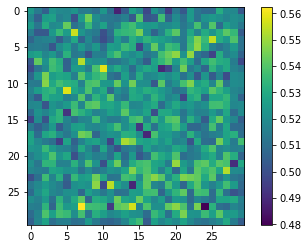

In [37]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

---

## 17.12 난 스케치를 할 테니 너는 채색을 하거라 (5) 학습 및 테스트하기

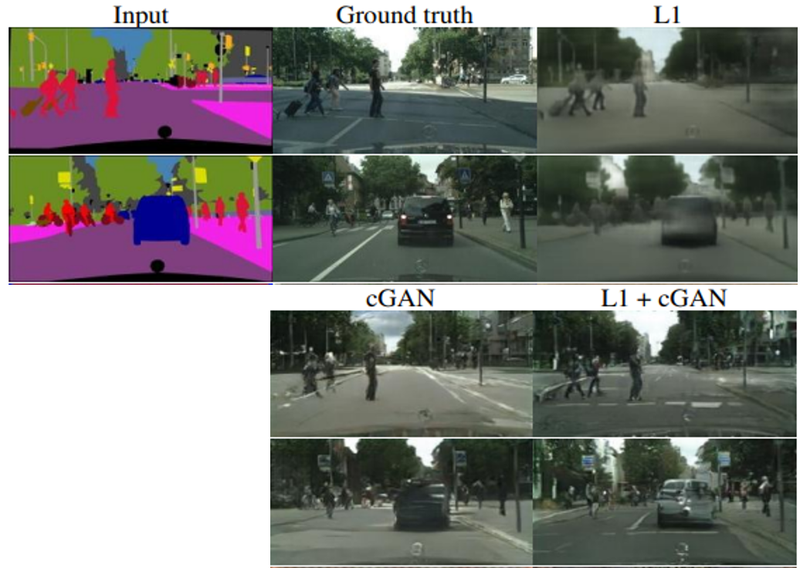

레이블 정보만 있는 입력에 대해 여러 손실 함수를 사용해 실제 이미지를 만들어 낸 결과는, 일반적인 GAN의 손실 함수에 L1을 추가로 이용했을 때 가장 실제에 가까운 이미지를 생성해 냈습니다. 이번 실험에서도 두 가지 손실 함수를 모두 사용해 봅시다.

In [39]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


- Generator의 손실 함수
    - 이 중 fake_disc는 Generator가 생성한 가짜 이미지를 Discriminator에 입력하여 얻어진 값이며, 실제 이미지를 뜻하는 "1"과 비교하기 위해 tf.ones_like()를 사용합니다. 
    - 또한 L1 손실을 계산하기 위해 생성한 가짜 이미지(fake_output)와 실제 이미지(real_output) 사이의 MAE(Mean Absolute Error)를 계산합니다.
    
- Discriminator의 손실 함수
    - Discriminator는 실제 이미지를 잘 구분해 내야 하므로 real_disc는 "1"로 채워진 벡터와 비교하고, fake_disc는 "0"으로 채워진 벡터와 비교합니다.

In [40]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


#### 가중치를 1회 업데이트하는 과정

In [41]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


In [42]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:1.1015                     
L1_loss:0.5357                     
Discriminator_loss:1.0176

EPOCH[1] - STEP[20]                     
Generator_loss:1.4384                     
L1_loss:0.3876                     
Discriminator_loss:0.7015

EPOCH[1] - STEP[30]                     
Generator_loss:1.2365                     
L1_loss:0.2501                     
Discriminator_loss:1.1056

EPOCH[1] - STEP[40]                     
Generator_loss:1.3817                     
L1_loss:0.3011                     
Discriminator_loss:1.3164

EPOCH[1] - STEP[50]                     
Generator_loss:1.1798                     
L1_loss:0.2796                     
Discriminator_loss:0.7922

EPOCH[1] - STEP[60]                     
Generator_loss:1.3384                     
L1_loss:0.2433                     
Discriminator_loss:1.6724

EPOCH[1] - STEP[70]                     
Generator_loss:1.8127                     
L1_loss:0.2706                    

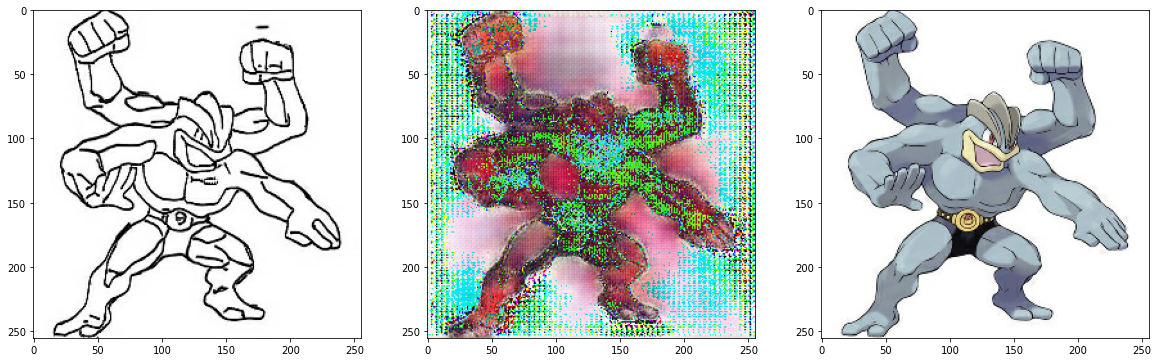

In [43]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))